Overleaf doc: https://www.overleaf.com/read/ysgbfhgmndrs

This notebook requires:
- jaxlib (`pip install jaxlib`)
- jax
- sympy
- scipy
- sympy2jax (`pip install sympy2jax`) -- but sympy's built-in lambdify should be sufficient for our uses

Not needed but in case we want to parse LaTeX:

- antlr4 python runtime (`conda install -c conda-forge antlr-python-runtime`) — for sympy's LaTeX parsing

# Setup

In [252]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [154]:
import jax
import jax.numpy as jnp
import sympy
# from sympy.parsing.latex import parse_latex
# from sympy2jax import sympy2jax
import matplotlib.pyplot as plt
import scipy
import scipy.constants as const
import numpy as np
import math
import scipy.special as sp
from jaxopt import Bisection
from tqdm.notebook import tqdm 
import inspect  # useful for looking into lambdified functions
import sys
from functools import partial

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
e = np.e
ln = np.log
ln_j = jnp.log
gamma_0 = sp.exp1
gamma_0_j = jax.scipy.special.exp1

In [5]:
%matplotlib notebook

In [6]:
# Ti(B_pm, B_p, p_aux, Eb)
# Te(B_pm, B_p, p_aux, Eb)
# DD_reac(Ti(B_pm, B_p, p_aux, Eb))
# DT_reac(Ti(B_pm, B_p, p_aux, Eb))

---

# Units used

* Temperature: keV
* Density: m^-3
* Field: T

# Cary's spreadsheet sanity check

Spreadsheet benchmark inputs:
* $B_p = 6$ T
* $B_{p,m} = 30$ T
*     --> $R_p = 5$
* $\beta_{limit} = 0.8$
* $E_b = 1000$ keV
* $r_b = 0.25$ m
* $L_p = 4$ m

Yields (ignoring finite $\beta$ effects on the electron temperature):
* $T_e = 77.1$ keV
* $n_{plug} = 9.68 \times 10^{19}$ m$^{-3}$

# Fundamental parameters

I'm filling out the parameters as I go along

## Sympy variables

In [538]:
# Machine / engineering parameters
[Eb, # keV
 beta,
 B_pm, # Tesla -- plug 
 B_p, # Tesla
 r_b,
 L_p,
 Ti,  # Placeholder (will be calculated later), keV
 Te,  # Placeholder (will be calculated later), keV
 DT_reac,  # Placeholder (evaluated after Ti and Te)
 DD_reac,  # Placeholder -- should really be split into nHe3 and pT at some point
 p_aux,
 T_frac,  # fraction of fuel that is tritium (assuming deuterium)
 Tep_fudge,  # fudge factor for electron temperature when running in a tandem configuration
 
 # Tandem parameters
 B_cc,
 n_ccr,  # central cell-to-plug density ratio
 Ti_ccr,  # central cell ion temeprature to plug electron temperature ratio, assumes Maxwellian & thermal eq
 Te_ccr,  # same, but for Te
 L_cc,
 
 # Engineering parameters
#  r_vr,  # vessel wall radius to plasma radius ratio
 Ef_DEC,  # direct energy converter efficiency
 Ef_TE,  # thermal-to-electric efficiency
 Ef_ECH, 
 Ef_NBI,
 Ef_RF
] = sympy.symbols('Eb '
                  'beta '
                  'B_pm '
                  'B_p '
                  'r_b '
                  'L_p '
                  'Ti '
                  'Te '
                  'DT_reac '
                  'DD_reac '
                  'p_aux '
                  'T_frac '
                  'Tep_fudge '
                  'B_cc '
                  'n_ccr '
                  'Ti_ccr '
                  'Te_ccr '
                  'L_cc '
#                   ' r_vr '
                  'Ef_DEC '
                  'Ef_TE '
                  'Ef_ECH '
                  'Ef_NBI '
                  'Ef_RF ')



f_Ti = sympy.Function('f_Ti ')
f_Te = sympy.Function('f_Te ')
f_DT_reac = sympy.Function('f_DT_reac ')
f_DD_reac = sympy.Function('f_DD_reac ')

# Physics parameters?
[mu,
 Z_eff,
 I_cooling,
 tau_alpha
] = sympy.symbols('mu '
                  'Z_eff '
                  'I_cooling '
                  'tau_alpha')

## plug_in_values

In [236]:
def sub_and_lambdify(equation, values_in, symbol_list_names=None):
    eq_in = equation.copy()  # Copy so as not to modify the original function
    eq_in = eq_in.subs(Ti, f_Ti(B_pm, B_p, p_aux, Eb))
    eq_in = eq_in.subs(Te, f_Te(B_pm, B_p, p_aux, Eb))
    eq_in = eq_in.subs(DD_reac, f_DD_reac(B_pm, B_p, p_aux, Eb))
    eq_in = eq_in.subs(DT_reac, f_DT_reac(B_pm, B_p, p_aux, Eb))
    jax_equation = (sympy.lambdify(list(eq_in.free_symbols), eq_in, [jnp, {'f_Ti': values_in['Ti'],
                                                                                'f_Te': values_in['Te'],
                                                                                'f_DD_reac': values_in['DD_reac'],
                                                                                'f_DT_reac': values_in['DT_reac']}]))
    # If we want to quickly solve for other quantities given Ti and Te, we just remove the dictionary above that calls the functions
    #   for calculating Ti and Te (and the reactivities) and put the numbers into the values dictionary. Functions are substituted above
    #   so we can calculate gradients all the way through the Ti and Te calculations for JAX
    
    arg_tuple = tuple(values_in[_.name] for _ in list(eq_in.free_symbols))  # Need to find position of arguments because it's not consistent run-to-run
    arg_order = [_.name for _ in list(eq_in.free_symbols)]
    
    # Return the indicies so we can easily pass in values to the jax function when we're evaluting from a larger set of values. 
    #   Useful for calculating other quantities (e.g., temperatures) when optimizing for another one.
    if symbol_list_names is not None:
        arg_idx = jnp.array([symbol_list_names.index(arg_order[_]) for _ in range(len(arg_order))])
    else: arg_idx = None
    
    return eq_in, jax_equation, arg_tuple, arg_idx

def evaluate_lambdified_func(sympy_eq_in, jax_eq_in, arg_tuple):
    return jax_eq_in(*arg_tuple)

def plug_in_values(equation, values_in):
    sympy_equation, jax_equation, arg_tuple, arg_idx = sub_and_lambdify(equation, values_in)
    result = evaluate_lambdified_func(sympy_equation, jax_equation, arg_tuple)
    return result

## JAX variables to optimize for

In [539]:
values = {
    'Eb': 1000.,
    'beta': 0.8,
    'B_pm': 30.,
    'B_p': 6.,
    'r_b': 0.25,
    'L_p': 4.,
    'p_aux': 0.0,  # this is in addition to synchotron losses (which are calculated separately)
    'T_frac': 0.5,
    'Tep_fudge': 0.5,
    
    'B_cc': 1.5,
    'n_cc_r': 0.25,
    'Ti_cc_r': 1.0,
    'Te_cc_r': 1.0,
    'L_cc': 20.0,
#     'a_v_r': ,
    'Ef_DEC': 0.7,
    'Ef_TE': 0.5,
    'Ef_ECH': 0.6,
    'Ef_NBI': 0.6,
    'Ef_RF': 0.9,
    
    'mu': 2.5,
    'Z_eff': 1,
    'I_cooling': 0,
    'tau_alpha': 0
}

## Flags

In [534]:
flags = {
    'simple_temps': False  # assumes Ti_plug = 2/3 E_inj and Te_plug = 0.09 log(Rm/(sqrt(1-beta))^0.4)
    'DD_cat': False,  # assumes DD fusion products are burned instantly
}

# Constants

In [10]:
E_alpha = 3.5  # MeV

# General formulae

## Cross section / reactivity paramterization

Accepts: ion temperature in keV. Yields: reactivity in cm$^3$/s

These constants are valid for 0.2-100 keV (Maxwellian) ion temperatures. Verified correct to 4 decimal places for 0.2, 1, and 10 keV.

In [11]:
DT_BG = 34.3827 # keV^0.5
DT_mrc2 = 1124656 # keV
DT_C1 = 1.17302e-9
DT_C2 = 1.51361e-2
DT_C3 = 7.51886e-2
DT_C4 = 4.60643e-3
DT_C5 = 1.35e-2
DT_C6 = -1.06750e-4
DT_C7 = 1.366e-5

In [12]:
DD_pT_BG = 31.3970 # keV^0.5
DD_pT_mrc2 = 937814 # keV
DD_pT_C1 = 5.65718e-12
DD_pT_C2 = 3.41267e-3
DD_pT_C3 = 1.99167e-3
DD_pT_C4 = 0
DD_pT_C5 = 1.05060e-5
DD_pT_C6 = 0
DD_pT_C7 = 0

In [13]:
DD_nHe_BG = 31.3970 # keV^0.5
DD_nHe_mrc2 = 937814 # keV
DD_nHe_C1 = 5.43360e-12
DD_nHe_C2 = 5.85778e-3
DD_nHe_C3 = 7.68222e-3
DD_nHe_C4 = 0
DD_nHe_C5 = -2.96400e-6
DD_nHe_C6 = 0
DD_nHe_C7 = 0

In [14]:
DT_theta = Ti / (1 -  Ti * (DT_C2 + Ti * (DT_C4 + Ti * DT_C6)) / (1 + Ti * (DT_C3 + Ti * (DT_C5 + Ti * DT_C7))))
DT_xi = (DT_BG ** 2 / (4 * DT_theta)) ** (1/3)
DT_reactivity = DT_C1 * DT_theta * (DT_xi / (DT_mrc2 * Ti ** 3)) ** 0.5 * sympy.E ** (-3 * DT_xi)

In [15]:
DD_pT_theta = Ti / (1 -  Ti * (DD_pT_C2 + Ti * (DD_pT_C4 + Ti * DD_pT_C6)) / (1 + Ti * (DD_pT_C3 + Ti * (DD_pT_C5 + Ti * DD_pT_C7))))
DD_pT_xi = (DD_pT_BG ** 2 / (4 * DD_pT_theta)) ** (1/3)
DD_pT_reactivity = DD_pT_C1 * DD_pT_theta * (DD_pT_xi / (DD_pT_mrc2 * Ti ** 3)) ** 0.5 * sympy.E ** (-3 * DD_pT_xi)

In [16]:
DD_nHe_theta = Ti / (1 -  Ti * (DD_nHe_C2 + Ti * (DD_nHe_C4 + Ti * DD_nHe_C6)) / (1 + Ti * (DD_nHe_C3 + Ti * (DD_nHe_C5 + Ti * DD_nHe_C7))))
DD_nHe_xi = (DD_nHe_BG ** 2 / (4 * DD_nHe_theta)) ** (1/3)
DD_nHe_reactivity = DD_nHe_C1 * DD_nHe_theta * (DD_nHe_xi / (DD_nHe_mrc2 * Ti ** 3)) ** 0.5 * sympy.E ** (-3 * DD_nHe_xi)

In [17]:
test_DD_nHe_theta = Ti / (1 -  Ti * (DD_nHe_C2 + Ti * (DD_nHe_C4 + Ti * DD_nHe_C6)) / (1 + Ti * (DD_nHe_C3 + Ti * (0.0 + Ti * DD_nHe_C7))))
test_DD_nHe_xi = (DD_nHe_BG ** 2 / (4 * test_DD_nHe_theta)) ** (1/3)
test_DD_nHe_reactivity = DD_nHe_C1 * test_DD_nHe_theta * (test_DD_nHe_xi / (DD_nHe_mrc2 * Ti ** 3)) ** 0.5 * sympy.E ** (-3 * test_DD_nHe_xi)

In [18]:
jax_DT_reactivity = sympy.lambdify(list(DT_reactivity.free_symbols), DT_reactivity, jax.numpy)
jax_DD_pT_reactivity = sympy.lambdify(list(DD_pT_reactivity.free_symbols), DD_pT_reactivity, jax.numpy)
jax_DD_nHe_reactivity = sympy.lambdify(list(DD_nHe_reactivity.free_symbols), DD_nHe_reactivity, jax.numpy)
test_jax_DD_nHe_reactivity = sympy.lambdify(list(test_DD_nHe_reactivity.free_symbols), test_DD_nHe_reactivity, jax.numpy)

## Cross section via interpolation from NRL

polyfit (isn't good) -- not used

In [19]:
def calc_lin_reactivity(coefficients, x):
    num_c = coefficients.shape[-1]
    num_x = x.shape[0]
    x_mat = 1 - jnp.triu(jnp.ones((num_c, num_c)))[jnp.newaxis, :, :].repeat(num_x, axis=0)
    x_mat = x_mat * x.reshape(num_x, 1, 1)
    x_mat = jnp.tri(num_c).transpose() + x_mat
#     print(x_mat)
    x = jnp.product(x_mat, axis=-2)
    return jnp.sum(x*coefficients, axis=1)

Linearly interpolate between reactivity datapoints from the NRL formulary (in log-log space)

In [20]:
linear_reactivity_temps = jnp.array([1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0])
linear_reactivity_DT = jnp.array([5.5e-21, 2.6e-19,  1.3e-17,  1.1e-16,  4.2e-16,  8.7e-16,  8.5e-16,  6.3e-16,  3.7e-16,  2.7e-16])
linear_reactivity_DD = jnp.array([1.5e-22, 5.4e-21, 1.8e-19, 1.2e-18, 5.2e-18, 2.1e-17, 4.5e-17, 8.8e-17, 1.8e-16, 2.2e-16])
linear_reactivity_DHe3 = jnp.array([1e-26, 1.4e-23, 6.7e-21, 2.3e-19, 3.8e-18, 5.4e-17, 1.6e-16, 2.4e-16, 2.3e-16, 1.8e-16])

In [21]:
lin_c = jnp.polyfit(linear_reactivity_temps, linear_reactivity_DD, deg=3)

In [206]:
def calc_DT_reactivity_linear(Ti):
    return jnp.e ** jnp.interp(jnp.log(Ti), jnp.log(linear_reactivity_temps), jnp.log(linear_reactivity_DT))

def calc_DD_reactivity_linear(Ti):
    return jnp.e ** jnp.interp(jnp.log(Ti), jnp.log(linear_reactivity_temps), jnp.log(linear_reactivity_DD))

def calc_DHe3_reactivity_linear(Ti):
    return jnp.e ** jnp.interp(jnp.log(Ti), jnp.log(linear_reactivity_temps), jnp.log(linear_reactivity_DHe3))

## Cross section comparison

<IPython.core.display.Javascript object>


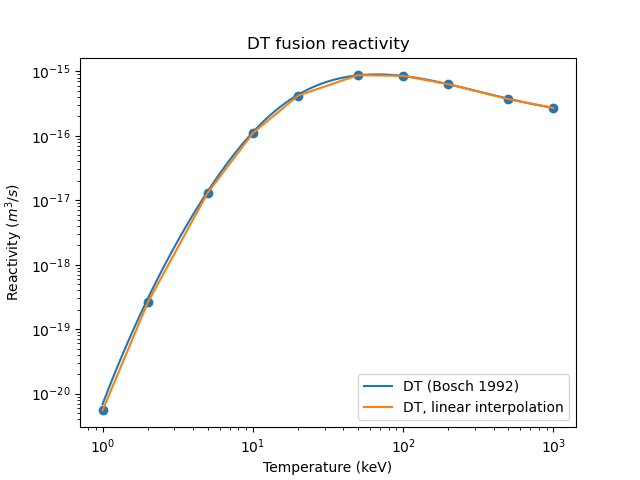

In [535]:
temp_plot = 10 ** jnp.linspace(0, 3, 100)
plt.figure()
plt.plot(temp_plot, jax_DT_reactivity(temp_plot), label='DT (Bosch 1992)')
# plt.plot(temp_plot, jax_DD_nHe_reactivity(temp_plot) + jax_DD_pT_reactivity(temp_plot), label='pT+nHe3 (Bosch 1992)')
# plt.plot(temp_plot, jax_DD_nHe_reactivity(temp_plot), label='nHe3 (Bosch 1992)')
# plt.plot(temp_plot, jax_DD_pT_reactivity(temp_plot), label='pT (Bosch 1992)')
# plt.plot(temp_plot, test_jax_DD_nHe_reactivity(temp_plot) + jax_DD_pT_reactivity(temp_plot), label='Test _ DD (pT+nHe3)')
plt.plot(temp_plot, calc_DT_reactivity_linear(temp_plot), label='DT, linear interpolation')
# plt.plot(temp_plot, calc_DD_reactivity_linear(temp_plot), label='log-space linear interpolation')
# plt.plot(temp_plot, calc_lin_reactivity(lin_c, temp_plot), label='DD, poly')
plt.scatter(linear_reactivity_temps, linear_reactivity_DT)
# plt.scatter(linear_reactivity_temps, linear_reactivity_DD, label="NRL datapoints")
# plt.plot(temp_plot, calc_DHe3_reactivity_linear(temp_plot), label='DHe3, linear')
plt.yscale('log')
plt.xscale('log')
plt.title('DT fusion reactivity')
plt.ylabel('Reactivity ($m^3/s$)')
plt.xlabel("Temperature (keV)")
plt.legend()
# plt.savefig('DT_reactivity.pdf')

<IPython.core.display.Javascript object>


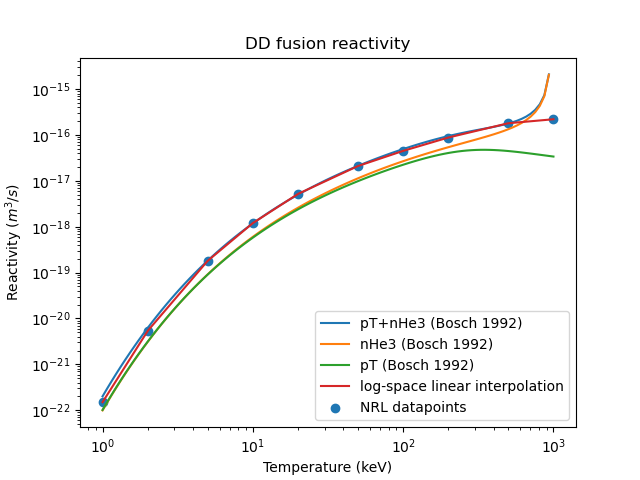

In [536]:
temp_plot = 10 ** jnp.linspace(0, 3, 100)
plt.figure()
# plt.plot(temp_plot, jax_DT_reactivity(temp_plot), label='DT')
plt.plot(temp_plot, jax_DD_nHe_reactivity(temp_plot) + jax_DD_pT_reactivity(temp_plot), label='pT+nHe3 (Bosch 1992)')
plt.plot(temp_plot, jax_DD_nHe_reactivity(temp_plot), label='nHe3 (Bosch 1992)')
plt.plot(temp_plot, jax_DD_pT_reactivity(temp_plot), label='pT (Bosch 1992)')
# plt.plot(temp_plot, test_jax_DD_nHe_reactivity(temp_plot) + jax_DD_pT_reactivity(temp_plot), label='Test _ DD (pT+nHe3)')
# plt.plot(temp_plot, calc_DT_reactivity_linear(temp_plot), label='DT, linear')
plt.plot(temp_plot, calc_DD_reactivity_linear(temp_plot), label='log-space linear interpolation')
# plt.plot(temp_plot, calc_lin_reactivity(lin_c, temp_plot), label='DD, poly')
# plt.scatter(linear_reactivity_temps, linear_reactivity_DT)
plt.scatter(linear_reactivity_temps, linear_reactivity_DD, label="NRL datapoints")
# plt.plot(temp_plot, calc_DHe3_reactivity_linear(temp_plot), label='DHe3, linear')
plt.yscale('log')
plt.xscale('log')
plt.title('DD fusion reactivity')
plt.ylabel('Reactivity ($m^3/s$)')
plt.xlabel("Temperature (keV)")
plt.legend()
# plt.savefig('DD_reactivity.pdf')

# Derived quantities

## Solving for Ti and Te

Ion temperature: $\frac{3}{2} \frac{T_i}{E_{beam}} = \frac{\exp{(-\alpha)} - \alpha \Gamma(0, \alpha)}{\Gamma(0, \alpha)}$

Electron temperature: $\frac{T_e}{E_{beam}} =  \left( \frac{T_i}{E_{beam}} \frac{2}{3} \frac{\alpha^2 \ln{R_m}^2}{(22.4)^2} \right)^{1/3}$

Energy balance: $E_{beam} + p_{aux} = T_i + 6T_e$

In [321]:
@jax.jit
def alpha_root_func(a, R):
    return ((e ** (-a) / gamma_0_j(a) - a))*2/3 + 6 * (((e ** (-a) / gamma_0_j(a) - a)) * a ** 2 * ln_j(R) ** 2/(22.4) ** 2 * 3/2) ** (1/3)

@jax.jit
def alpha_eq(a, R_in, power_aux_in):
    return alpha_root_func(a, R_in) - (1 + power_aux_in)

@jax.jit
def find_alpha(R_in, power_aux_in):
    bisec = Bisection(optimality_fun=alpha_eq, lower=0.001, upper=200.0, tol=1e-4, check_bracket=False, unroll=False, jit=True)  # Check_bracket needs to be False to be JIT'd
    alpha = bisec.run(R_in=R_in, power_aux_in=power_aux_in).params
    return alpha

@jax.jit
def Ti_given_alpha(a):
    return ((e ** (-a) / gamma_0_j(a) - a))*2/3

@jax.jit
def Te_given_alpha(a, R):
    return (((e ** (-a) / gamma_0_j(a) - a)) * a ** 2 * ln_j(R) ** 2/(22.4) ** 2 * 2/3) ** (1/3)

@jax.jit
def find_Ti_and_Te(B_pm, B_p, p_aux, Eb):
    R_in = B_pm / B_p
    E_beam = Eb
    
    alpha = find_alpha(R_in, p_aux)
    Ti = Ti_given_alpha(alpha)
    Te = Te_given_alpha(alpha, R_in)
    return Ti * E_beam, Te * E_beam

In [217]:
@jax.jit
def find_Ti(B_pm, B_p, p_aux, Eb):
    return find_Ti_and_Te(B_pm, B_p, p_aux, Eb)[0]

@jax.jit
def find_Te(B_pm, B_p, p_aux, Eb):
    return find_Ti_and_Te(B_pm, B_p, p_aux, Eb)[1]

@jax.jit
def find_DT_reac(B_pm, B_p, p_aux, Eb):
    return calc_DT_reactivity_linear(find_Ti_and_Te(B_pm, B_p, p_aux, Eb)[0])

@jax.jit
def find_DD_reac(B_pm, B_p, p_aux, Eb):
    return calc_DD_reactivity_linear(find_Ti_and_Te(B_pm, B_p, p_aux, Eb)[0])

### values of Ti and Te

If we're using simple calculations, electron temperature is then: 
$T_e = 0.089 E_b \log_{10} \left( R_p \right)^{0.4} = 0.089 E_b \log_{10} \left(\frac{R_p}{1-\beta} \right)^{0.4}$

In [218]:
if flags['simple_temps']:
    values = {**values, **{'DT_reac': calc_DT_reactivity_linear,
                           'DD_reac': calc_DD_reactivity_linear}}
    Te = 0.089 * Eb * ((sympy.log(R_p / (1))/sympy.log(10)) ** 0.4)
    Ti = 0.66 * Eb
else:
    values = {**values, **{'Ti': find_Ti,
                           'Te': find_Te,
                           'DT_reac': find_DT_reac,
                           'DD_reac': find_DD_reac}}

Mirror ratio $R_{\text{plug}} = \frac{B_m}{B_p}$

In [30]:
R_p = B_pm / B_p; R_p

B_pm/B_p

## End cells / plugs

Radius at midplane $a_{\text{plug}} = r_b \sqrt{\frac{B_m}{B_p}} = r_b \sqrt{R_{plug}}$

In [31]:
a_plug = r_b * sympy.sqrt(R_p); a_plug

r_b*sqrt(B_pm/B_p)

Volume $V_p = L_p \pi a_p^2$

In [32]:
V_p = L_p * sympy.pi * a_plug ** 2; V_p

pi*B_pm*L_p*r_b**2/B_p

### n_plug

Density at a given beta: $n_{\text{plug}} = B_p^2 \frac{\beta_{\text{limit}}}{2\mu_0 |e|\left(T_{\text{ion}} + T_e \right)}$

In [33]:
const.mu_0 * const.elementary_charge * 2 * 1000 / 1e-20

0.04026709076694141

In [210]:
n_plug = (B_p) ** 2 * beta / (2 * const.mu_0 * const.elementary_charge * 1000 * (Ti + Te))

In [211]:
plug_in_values(n_plug, values)

DeviceArray(1.53884884e+20, dtype=float64)

Total particle number: $N_{\text{tot}} = V_p n_{\text{plug}}$

In [41]:
N_tot = V_p * n_plug; N_tot

pi*B_p*B_pm*L_p*beta*r_b**2/(4.02670907669414e-22*Te + 4.02670907669414e-22*Ti)

### tau fowler/baldwin

**General formula:** Particle conefinement time $\tau_{\text{Fowler/Baldwin}} = 2.8 \cdot 10^{12} \frac{E_b^{3/2}}{n_e} \log_{10} R_m$

In [42]:
tau_Fowler_Baldwin = 2.4 * 10 ** 16 * Eb ** (3/2) / n_plug * sympy.log(R_p / sympy.sqrt(1 - beta)) / sympy.log(10); tau_Fowler_Baldwin

2.4e+16*Eb**1.5*(4.02670907669414e-22*Te + 4.02670907669414e-22*Ti)*log(B_pm/(B_p*sqrt(1 - beta)))/(B_p**2*beta*log(10))

In [43]:
plug_in_values(tau_Fowler_Baldwin, values)

DeviceArray(5.17691283, dtype=float64)

Particles lost per second: $\frac{dN}{dt} = \frac{N_{\text{tot}}}{\tau_{\text{Fowler/Baldwin}}}$

In [44]:
dN_dt = N_tot / tau_Fowler_Baldwin

**General formula:** Ion gyroradius at center of the plug: $\rho_i = \frac{m v_\perp}{q B} = 3.22\cdot 10^{-3} \frac{\sqrt{\mu E_{\text{ion}}}}{B_p}$

In [45]:
rho_i = 3.22 * 10 ** -3 * sympy.sqrt(mu * Ti) / B_p; rho_i

0.00322*sqrt(Ti*mu)/B_p

Number of gryoradii in the plasma radius: $N_{\text{gyro}} = \frac{a_p}{\rho_i}$

In [46]:
N_gyro = a_plug / rho_i; N_gyro

310.55900621118*B_p*r_b*sqrt(B_pm/B_p)/sqrt(Ti*mu)

NBI current (A): $I_{\text{NBI}}=|e|\frac{dN}{dt}$

In [47]:
I_NBI = const.elementary_charge * dN_dt

**General formula:** Coulomb logarithms: $\lambda_{ei} = 24 - 0.5\ln{n_e} + \ln{T_e}$

In [48]:
lambda_ei = 24 - 0.5 * sympy.log(n_plug) + sympy.log(Te)

**General formula:** Slowing down times: $\tau_{i,\text{slow}} = 0.1 \frac{\mu T_e^{3/2}}{n_{20} Z^2 \lambda_{ei}}$

In [49]:
tau_i_slow = 0.1 * mu * Te ** (3/2) / (n_plug / 10 ** 20 * Z_eff ** 2 * lambda_ei)

Electron heating by fast ions (MW): $10^{-3}\frac{I_{\text{NBI}}E_b}{\tau_{\text{slow}}}$

In [50]:
P_e_heating_fastI = 10 ** -3 * I_NBI * Eb / tau_i_slow

**General formula:** Lorentz factor: $\gamma = \sqrt{1 - \frac{T_e}{m_e c^2}} = \sqrt{1 - \frac{T_e}{511 \text{keV}}}$

In [51]:
gamma = sympy.sqrt(1 - Te / 511)

sqrt(1 - Te/511)

### power losses

Synchrotron radiation power loss (MW): $ P_{\text{synch}} = 6\cdot10^{-3} V_p n_{20} T_e \gamma^2 B_p^2$

In [52]:
P_synch = 6 * 10 ** -3 * V_p * n_plug / 10 ** 20 * Te * gamma ** 2 * B_p ** 2

6.0e-23*pi*B_p**3*B_pm*L_p*Te*beta*r_b**2*(1 - Te/511)/(4.02670907669414e-22*Te + 4.02670907669414e-22*Ti)

In [53]:
plug_in_values(P_synch, values)/20

DeviceArray(4.31813085, dtype=float64)

Bremsstrahlung radiation power loss (MW): $P_{\text{brem}} = 5.35\cdot10^{-3} n_{20}^2 Z_{\text{eff}}\sqrt{T_e} V_p$

In [54]:
P_brem = 5.35 * 10 ** -3 * (n_plug / 10 ** 20) ** 2 * Z_eff * sympy.sqrt(Te) * V_p

In [277]:
plug_in_values(P_brem, values)

DeviceArray(0.43938033, dtype=float64)

Power loss from escaping electrons (MW): $P_{\text{e,endloss}} = 10^{-3}(I_{\text{NBI}}+I_{\text{cooling}})\cdot 7 T_e$

In [56]:
P_e_endloss = 10 ** -3 * (I_NBI + I_cooling) * 7 * Te

Te*(288201.797210393*pi*B_p**3*B_pm*L_p*beta**2*r_b**2*log(10)/(Eb**1.5*(Te + Ti)**2*log(B_pm/(B_p*sqrt(1 - beta)))) + 0.007*I_cooling)

Power loss from escaping fast ions (MW): $P_{\text{i,endloss}} = 10^{-3} I_{\text{NBI}} \left(E_b-T_e\right)$

In [57]:
P_i_endloss = 10 ** -3 * I_NBI * (Eb - Te)

41171.6853157704*pi*B_p**3*B_pm*L_p*beta**2*r_b**2*(Eb - Te)*log(10)/(Eb**1.5*(Te + Ti)**2*log(B_pm/(B_p*sqrt(1 - beta))))

Injected NBI Power (MW): $P_{\text{NBI}} = 10^{-3}I_{\text{NBI}} E_b$

In [58]:
P_NBI = 10 ** -3 * I_NBI * Eb; P_NBI

41171.6853157704*pi*B_p**3*B_pm*L_p*beta**2*r_b**2*log(10)/(Eb**0.5*(Te + Ti)**2*log(B_pm/(B_p*sqrt(1 - beta))))

In [59]:
plug_in_values(P_NBI, values)

DeviceArray(18.6805481, dtype=float64)

Injected ECH Power (MW): $P_{\text{ECH}} = \frac{P_{\text{synch}}}{20} +P_{\text{e,endloss}} - \left(\text{Electron heating from fast ions}\right)$
* ignore P_e_endloss and P_e_heating_fastI because that's already included in the reduced model power balance (I think); include if using simple temperature model

In [385]:
if flags['simple_temps']:
    P_ECH = P_synch / 20 + P_brem + P_e_endloss - P_e_heating_fastI
else:
    P_ECH = P_synch / 20 + P_brem

In [384]:
plug_in_values(P_ECH, values)

DeviceArray(4.31341324, dtype=float64)

In [544]:
P_heating_plug = P_ECH + P_NBI  # + P_RF

### fusion power

Detuerium and tritium densities

In [61]:
n_plug_D = (1 - T_frac) * n_plug
n_plug_T = T_frac * n_plug

DT fusion reaction rate (#/s). Here we assume a 50-50 DT fuel mixture: $R_{\text{x,plug,DT}}=V_p \frac{n_{\text{plug}}^2}{4} \langle\sigma v\rangle_{DT}$

Reminder: DT_reac and DD_reac are functions

In [62]:
# Rx_plug_DT = V_p * n_plug ** 2 / 4 * DT_reactivity  # If using Bosch 1992 parameterization
Rx_plug_DT = V_p * (n_plug_D * n_plug_T) * DT_reac

DD fusion reaction rate (#/s). Here we assume a 50-50 DT fuel mixture: $R_{\text{x,plug,DD}}=V_p \left(\frac{n_{\text{plug}}}{2} \right)^2 \langle\sigma v\rangle_{DD} \frac{1}{2}$

In [63]:
# Rx_plug_DD = V_p * n_plug ** 2 * (DD_pT_reactivity + DD_nHe_reactivity) / 2  # If using Bosch 1992 parameterization
Rx_plug_DD = V_p * n_plug_D ** 2 * (DD_reac) / 2

Fusion power (MW): $P_{\text{plug}}=17.6|e|R_{\text{x,plug}}$ -- we're just focusing on DT for now. Including DD it'd be: $P_{\text{plug}}=17.6|e|R_{\text{x,plug,DT}} + \frac{4.03+3.27}{2}|e|R_{\text{x,plug,DD}}$

In [64]:
P_fus_plug_DT = 17.6 * const.elementary_charge * Rx_plug_DT * 1e-6  # 1e-6 converts W to MW

In [65]:
P_fus_plug_DD = (4.02 + 3.27)/2 * const.elementary_charge * Rx_plug_DD * 1e-6  # 1e-6 converts W to MW; the 1/2 assumes 50-50 branching ratio (decent approx)

In [537]:
P_fus_plug_DD_cat = (17.6 + 18.3) * const.elementary_charge * Rx_plug_DD * 1e-6  # multiplying by Rx_plug_DD because this depends on the DD reaction rate

In [540]:
if flags['DD_cat']:
    P_fus_plug = P_fus_plug_DT + P_fus_plug_DD + P_fus_plug_DD_cat
else:
    P_fus_plug = P_fus_plug_DT + P_fus_plug_DD

In [67]:
plug_in_values(P_fus_plug, values)

DeviceArray(29.07565337, dtype=float64)

Lawson Triple Product (keV$\cdot$s/m$^3$): $\tau_{\text{Fowler/Baldwin}} n T_i$

In [68]:
triple_product = tau_Fowler_Baldwin * n_plug * Ti

Neutron Flux, DT only (MW/m$^2$): $\frac{14}{17.6}\frac{P_{\text{plug}}}{4\pi a_{\text{wall}}^2}$ for DT. DD adds a component with $\frac{2.45}{4.02 + 3.27}$

In [69]:
neutron_flux = (14 / 17.6 * P_fus_plug_DT + 2.45 / (4.02 + 3.27)) * P_fus_plug_DD / (4 * const.pi * a_plug ** 2)

In [70]:
plug_in_values(2.45 / (4.02 + 3.27) * P_fus_plug_DD / (4 * const.pi * a_plug ** 2), values)

DeviceArray(0.08543041, dtype=float64)

In [71]:
plug_in_values(14 / 17.6 * P_fus_plug_DT / (4 * const.pi * a_plug ** 2), values)

DeviceArray(5.68738488, dtype=float64)

In [72]:
plug_in_values(neutron_flux, values)

DeviceArray(5.76279043, dtype=float64)

Burnup fraction, DT: $\frac{R_{\text{x,plug,DT}}}{dN/dt}$

In [73]:
frac_burnup = Rx_plug_DT / dN_dt

# Q_plug

## Evaluate Ti and Te

$Q_{\text{plug}}$: $Q_{\text{plug}} = \frac{P_{\text{plug}}}{P_{\text{injected}}}$ (power in MW)

In [375]:
plug_in_values(P_ECH, values)

DeviceArray(4.75279357, dtype=float64)

In [376]:
Q_plug = P_fus_plug / (P_NBI + P_ECH)

In [377]:
plug_in_values((1.0 * Ti), values)

DeviceArray(386.7831713, dtype=float64)

In [378]:
plug_in_values((1.0 * Te), values)

DeviceArray(77.99558971, dtype=float64)

## Evaluate Q

In [380]:
values

{'Eb': 1000.0,
 'beta': 0.8,
 'B_pm': 30.0,
 'B_p': 6.0,
 'r_b': 0.25,
 'L_p': 4.0,
 'p_aux': 0.0,
 'T_frac': 0.5,
 'mu': 2.5,
 'Z_eff': 1,
 'I_cooling': 0,
 'tau_alpha': 0,
 'Ti': <CompiledFunction of <function find_Ti at 0x7f99f9f86d40>>,
 'Te': <CompiledFunction of <function find_Te at 0x7f99f9f8e170>>,
 'DT_reac': <CompiledFunction of <function find_DT_reac at 0x7f9a08882050>>,
 'DD_reac': <CompiledFunction of <function find_DD_reac at 0x7f99fa1cdb40>>}

In [379]:
plug_in_values(Q_plug, values)

DeviceArray(1.24192657, dtype=float64)

* Ti/Ebeam = 2/3 --> Q_plug = 0.68327016 (spreadsheet says 0.686)
* Ti/Ebeam = 0.6 --> Q_plug = 0.7356443

## Triple product, energy confinement time, etc...

In [212]:
plug_in_values(triple_product, values)

DeviceArray(3.07771648e+23, dtype=float64)

In [213]:
plug_in_values(n_plug * tau_Fowler_Baldwin, values)

DeviceArray(7.95721403e+20, dtype=float64, weak_type=True)

Energy confinement time $\tau_E = W_p / P_{\text{heating}}$ (power balance) (volume is overestimated — a linear falloff would cut it by a third):

In [83]:
plug_in_values((V_p * n_plug * 1000 * const.elementary_charge * (Ti + Te) * 3/2) / (1e6 * P_NBI), values)

DeviceArray(3.61338434, dtype=float64)

### alpha particle (broken)

$\alpha$ particle density ($10^{20}m^{-3}$): $n_{\alpha} = \frac{I_{\text{NBI}} Q_{\text{plug}} \tau_{\alpha} E_b}{16 V_p E_{\alpha}}$

In [84]:
n_alpha = I_NBI * Q_plug * tau_alpha * Eb / (16 * V_p * E_alpha)

$Z_{\text{eff}}$: $Z_{\text{eff}} = 1 +2n_{\alpha}$

In [85]:
Z_eff = 1 + 2 * n_alpha

In [86]:
plug_in_values(Z_eff, values)

DeviceArray(1., dtype=float64)

# Tandem mirror calculations

In [512]:
a_cc = r_b * sympy.sqrt(B_pm / B_cc)

In [513]:
R_cc = B_pm / B_cc

In [526]:
V_cc = const.pi * a_cc ** 2 * L_cc

In [ ]:
# P_needed_for_end_plug = 2 * P_

In [515]:
n_cc = n_ccr * n_plug
T_ic = Ti_ccr * Te
T_ec = Te_ccr * Te

In [516]:
beta_cc = 4.0267e-25 * n_cc * (T_ic + T_ec) * 1000 / B_cc ** 2

In [518]:
Pastukhov = sympy.log(2 * B_pm / B_cc * 1 / sympy.sqrt(1 - beta_cc) + 1) * sympy.log(n_plug / n_cc) * (n_plug / n_cc) ** (Te / T_ic)

In [519]:
tau_ii_cc = 1.25e16 * T_ic ** (3/2) * sympy.sqrt(mu) / n_cc / (Z_eff ** 4)

In [521]:
chi_ETG = 0.1 * T_ec ** (3/2) / B_cc

In [522]:
tau_ETG = a_cc ** 2 / chi_ETG

In [523]:
tau_E_cc = Pastukhov * tau_ii_cc

In [525]:
P_loss_cc = 1.5 * 0.016 * const.pi * a_cc ** 2 * n_cc * (T_ic + T_ec) / tau_E_cc

## tandem fusion power

Detuerium and tritium densities

In [527]:
n_cc_D = (1 - T_frac) * n_cc
n_cc_T = T_frac * n_cc

DT fusion reaction rate (#/s). Here we assume a 50-50 DT fuel mixture: $R_{\text{x,plug,DT}}=V_p \frac{n_{\text{plug}}^2}{4} \langle\sigma v\rangle_{DT}$

In [528]:
# Rx_plug_DT = V_p * n_plug ** 2 / 4 * DT_reactivity  # If using Bosch 1992 parameterization
Rx_cc_DT = V_cc * (n_cc_D * n_cc_T) * DT_reac

DD fusion reaction rate (#/s). Here we assume a 50-50 DT fuel mixture: $R_{\text{x,plug,DD}}=V_p \left(\frac{n_{\text{plug}}}{2} \right)^2 \langle\sigma v\rangle_{DD} \frac{1}{2}$

In [529]:
# Rx_plug_DD = V_p * n_plug ** 2 * (DD_pT_reactivity + DD_nHe_reactivity) / 2  # If using Bosch 1992 parameterization
Rx_cc_DD = V_cc * n_cc_D ** 2 * (DD_reac) / 2

Fusion power (MW): $P_{\text{plug}}=17.6|e|R_{\text{x,plug}}$ -- we're just focusing on DT for now. Including DD it'd be: $P_{\text{plug}}=17.6|e|R_{\text{x,plug,DT}} + \frac{4.03+3.27}{2}|e|R_{\text{x,plug,DD}}$

In [530]:
P_fus_cc_DT = 17.6 * const.elementary_charge * Rx_cc_DT * 1e-6  # 1e-6 converts W to MW

In [531]:
P_fus_cc_DD = (4.02 + 3.27)/2 * const.elementary_charge * Rx_cc_DD * 1e-6  # 1e-6 converts W to MW

In [541]:
P_fus_cc_DD_cat = (17.6 + 18.3) * const.elementary_charge * Rx_plug_DD * 1e-6  # multiplying by Rx_plug_DD because this depends on the DD reaction rate

In [542]:
if flags['DD_cat']:
    P_fus_cc = P_fus_cc_DT + P_fus_cc_DD + P_fus_cc_DD_cat
else:
    P_fus_cc = P_fus_cc_DT + P_fus_cc_DD

Keep in mind this is total fusion power, not fusion power per meter as defined in Cary's spreadsheet

In [543]:
P_fus_total = P_fus_cc + 2 * P_fus_plug

In [ ]:
# P_HHFW aka P_RF

L_breakeven: lenght of the central cell for breakeven (including fusion power from the endplugs. Perhaps a useful tandem mirror metric:

In [546]:
L_breakeven_cc = 2 * (P_heating_plug - P_fus_plug) * L_cc / P_fus_cc

## tandem power balance and Q

In [547]:
Q_tandem = P_fus_total / (2 * P_heating_plug)

In [548]:
P_electric_in = Ef_ECH * 2 * P_ECH + Ef_NBI * 2 * P_NBI  # + RF or HHFW

In [ ]:
P_recirculating = Ef_DEC * (FUSION POWER, CHARGED)

# Optimizing Q_plug

In [386]:
values_to_opt = values.copy()

Substitute in temperature and reactivities functions into the sympy equation and then lambdify

In [387]:
Q_plug_func_sympy, Q_plug_function, Q_arg_tuple, Q_arg_idx = sub_and_lambdify(Q_plug - 1/B_p, values_to_opt)

Build gradient function (only need to do this once!)

In [395]:
grad_Q_func = jax.jit(jax.grad(Q_plug_function, jnp.arange(len(symbol_list))))

Optimize for:
* B_pm
* B_p
* r_b
* L_p
* T_frac
* Eb

In [396]:
opt_symbol_list = [B_pm, B_p, r_b, L_p, T_frac, Eb]
# opt_symbol_list = [T_frac]

Create mask so that parameters we don't want to optimize remain constant

In [497]:
symbol_list = list(Q_plug_func_sympy.free_symbols)
symbol_list_names = [sym.name for sym in symbol_list]
print(symbol_list)
opt_idx = [symbol_list.index(sym) for sym in opt_symbol_list]
opt_idx_mask = np.zeros(len(symbol_list))
opt_idx_mask[opt_idx] = 1
print(opt_idx_mask)

[B_pm, Z_eff, B_p, L_p, r_b, T_frac, p_aux, beta, Eb]
[1. 0. 1. 1. 1. 1. 0. 0. 1.]


## Optimization loop

In [494]:
loop_values = []
loop_Q_grad = []
loop_values.append(jnp.array(Q_arg_tuple))
loop_Q_grad.append(jnp.zeros(9))

for i in tqdm(range(5000)):
    grad_Q = -jnp.array(grad_Q_func(*tuple(loop_values[i]))) * opt_idx_mask * 1e-2
#     if i > 1000:
    new_value = loop_values[-1] - (grad_Q + 0.99 * loop_Q_grad[-1])
#     else:
#         new_value = loop_values[-1] - grad_Q
    loop_values.append(new_value)
    loop_Q_grad.append(grad_Q)

  0%|          | 0/5000 [00:00<?, ?it/s]

## Plot Q and gradient norm

<IPython.core.display.Javascript object>


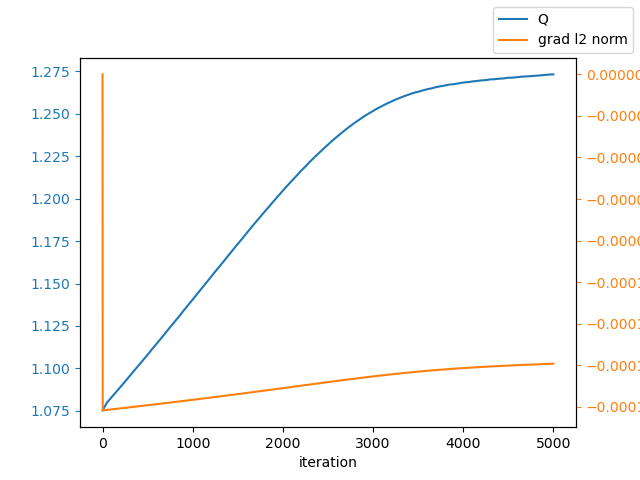

  0%|          | 0/101 [00:00<?, ?it/s]

In [496]:
fig, axQ = plt.subplots()
axQ.plot(np.arange(0, 5001, 50), [Q_plug_function(*tuple(_) ) for _ in tqdm(loop_values[::50])], label='Q', color="#1f77b4")
axQ.tick_params(colors="#1f77b4", axis='y')
# axQ.plot(Q_plug_function(*tuple([np.array(loop_values).transpose()[_, :] for _ in tqdm(range(8))])), label='Q')
axGrad = axQ.twinx()
# axGrad.plot(np.sqrt(np.sum(np.array(loop_Q_grad) ** 2, axis=1)), color='#ff7f0e', label='grad l2 norm')
axGrad.plot(np.array(loop_Q_grad)[:, 0], color='#ff7f0e', label='grad l2 norm')
axGrad.tick_params(colors="#ff7f0e", axis='y')
axQ.set_xlabel('iteration')
fig.legend()

In [464]:
# fig.savefig('Q_opt.pdf')

## Other plots

In [415]:
Te_subbed, Te_jaxed, Te_arg_tuple, Te_arg_idx = sub_and_lambdify(1.0 * Te, values_to_opt, symbol_list_names)
Ti_subbed, Ti_jaxed, Ti_arg_tuple, Ti_arg_idx = sub_and_lambdify(1.0 * Ti, values_to_opt, symbol_list_names)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


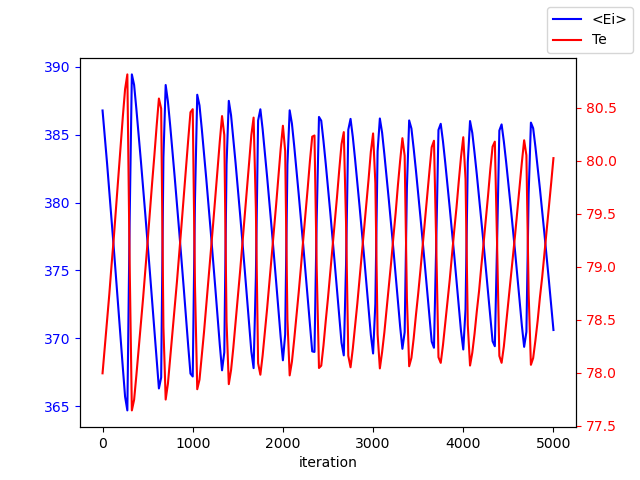

In [484]:
Te_plot = [Te_jaxed(*tuple(loop_values[i][Te_arg_idx])) for i in tqdm(range(0, 5001, 25))]
Ti_plot = [Ti_jaxed(*tuple(loop_values[i][Ti_arg_idx])) for i in tqdm(range(0, 5001, 25))]

figT, axTi = plt.subplots()

axTi.plot(np.arange(0, 5001, 25), Ti_plot, color='blue', label='<Ei>')
axTi.tick_params(colors='blue', axis='y')
axTe = axTi.twinx()
axTe.plot(np.arange(0, 5001, 25), Te_plot, color='red', label='Te')
axTe.tick_params(colors='red', axis='y')
axTi.set_xlabel('iteration')
figT.legend()

In [418]:
# figT.savefig('temp_change.pdf')

In [491]:
print("symbol \t value_i \t value_f \t RMS grad")
for i in range(len(symbol_list)):
    print(symbol_list[i].name + ":\t {:.4e}".format(loop_values[0][i]) + ":\t {:.4e}".format(loop_values[-1][i]), "\t {:.4e}".format(np.sqrt(np.sum(np.array(loop_Q_grad[0:-1]) ** 2, axis=0))[i]))

symbol 	 value_i 	 value_f 	 RMS grad
B_pm:	 3.0000e+01:	 nan 	 nan
Z_eff:	 1.0000e+00:	 nan 	 nan
B_p:	 6.0000e+00:	 nan 	 nan
L_p:	 4.0000e+00:	 nan 	 nan
r_b:	 2.5000e-01:	 nan 	 nan
T_frac:	 5.0000e-01:	 nan 	 nan
p_aux:	 0.0000e+00:	 0.0000e+00 	 0.0000e+00
beta:	 8.0000e-01:	 nan 	 nan
Eb:	 1.0000e+03:	 nan 	 nan
